# Importing Libraries

In [ ]:
!pip install googlesearch-python tldextract

In [ ]:
import pandas as pd
import re
from urllib.parse import urlparse
import numpy as np
import tldextract
from googlesearch import search
import random
from time import sleep
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

# DATASET

In [ ]:
df = pd.read_csv("malicious_phish.csv")
df.head(4)

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement


In [ ]:
df.tail(4)

,url,type
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,phishing
651188,www.gamespot.com/xbox360/action/deadspace/,phishing
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),phishing
651190,www.angelfire.com/goth/devilmaycrytonite/,phishing


# DATA UNDERSTANDING

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651191 entries, 0 to 651190
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   url     651191 non-null  object
 1   type    651191 non-null  object
dtypes: object(2)
memory usage: 9.9+ MB


In [ ]:
df.isnull().sum()

url     0
type    0
dtype: int64

In [ ]:
df['type'].value_counts()

benign        428103
defacement     96457
phishing       94111
malware        32520
Name: type, dtype: int64

# EDA

In [ ]:
df['url'] = df['url'].replace('www.', '', regex=True) #  "www." gereksiz bir özellik olduğu için onu siliyoruz.

In [ ]:
duplicated_rows = df.duplicated(subset='url')      # ur kolonunda aynı olanları görüyoruz
duplicate_data = df[duplicated_rows]
duplicate_data

,url,type
876,http://9779.info/%E4%BA%94%E8%B0%B7%E6%9D%82%E...,malware
1361,http://portal.dddgaming.com/docs/rules/15022/c...,malware
1822,http://824555.com/app/member/SportOption.php?u...,malware
1989,http://chinacxyy.com/newscodejs.asp?lm2=201&li...,malware
2963,http://bruynzeelmultipanel.be/index.php?option...,defacement
...,...,...
634694,ias.uwe.ac.uk/Robots/gwonline/gwonline.html,phishing
638955,videolan.org/vlc/,phishing
647128,gamecolony.com/hearts_game_rules.html,phishing
647750,freewebs.com/keepersofultramar/,phishing


In [ ]:
df = df.drop_duplicates(subset='url', keep='first')    # url kolonunda aynı olanları siliyoruz.

SAME DOMAİNS

---
df['dup_domain'] = df['url'].apply(lambda i: tldextract.extract(i).domain + "." + tldextract.extract(i).suffix)
duplicated_rows = df.duplicated(subset='dup_domain')
duplicate_data = df[duplicated_rows]
duplicate_data

df.drop_duplicates(subset='dup_domain', keep='first', inplace=True)
df = df.drop(['dup_domain'],axis=1)


In [ ]:
type_map = {"benign": 0, "defacement": 1, "phishing": 2, "malware": 3}          # Tiplere label encoding yapıyoruz dict içine attıktan sonra map ile types_label_encode kolonunda yazıyoruz.
df["types_label_encode"] = df["type"].map(type_map)

<ipython-input-12-5a33bcee7319>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["types_label_encode"] = df["type"].map(type_map)


In [ ]:
def nums(url):
  match = re.search('1|2|3|4|5|6|7|8|9|0',url)        # re ile 1,2,3,4,5,6,7,8,9,10 var mı yok mu ona bakıyoruz
  if match:
    return 1
  else:
    return 0

def is_ip(url):
  ip = re.findall( r'[0-9]+(?:\.[0-9]+){3}', url)      # urlin ip olup olmadığına bakıyoruz.

  if ip:
    return 1
  else:
    return 0

def short(url):
    match = re.search('bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|'
                      'yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|'
                      'short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|'                           #bunlar kısaltma linkler.  attacker.com/getpasswd yi bit.ly/bedava100freespin gibi yapabilirler
                      'doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|'
                      'db\.tt|qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|'
                      'q\.gs|is\.gd|po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|'
                      'x\.co|prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|'
                      'tr\.im|link\.zip\.net',
                      url)
    if match:
        return 1
    else:
        return 0

def abnormal_url(url):
    hostname = str(urlparse(url).hostname)
    if hostname:
        match = re.search(hostname, url)              #burda  dict olup olamdığına bakıyoruz.  eymentakak.com/asdasdas  eymentakak.com gibi
        if match:
            return 1
    return 0

df['short_url'] = df['url'].apply(lambda i: short(i))
df['count-nums'] = df['url'].apply(lambda i: nums(i))
df['is-ip'] = df['url'].apply(lambda i: is_ip(i))
df['abnormal-url'] = df['url'].apply(lambda i: abnormal_url(i))           #yukarıda ki açıklamaları burda uygulamaya döküyoruz. lambda ile her fonksiyonu tek tek çağırıyoruz.

In [ ]:
special_chars = ['@','?','-','=','.','#','%','+','$','!','*',',','//']       # özel karakterleri bir liste içine alıyoruz.
for a in special_chars:
    df[a] = df['url'].apply(lambda i: i.count(a))     #for döngüsü ile her karakter adına bir kolon açıp lambda fonksiyonu ve count metodu kullanarak sayıyoruz.

In [ ]:
df['count-https'] = df['url'].apply(lambda i : i.count('https'))      # https var mı kaç tane var.
df['count-http'] = df['url'].apply(lambda i : i.count('http'))        # https var mı kaç tane var.
df['url_length'] = df['url'].apply(lambda i: len(str(i)))             # URL uzunluğuna bakıyoruz.
df["domain-count-nums"] = df['url'].apply(lambda i: nums(tldextract.extract(i).domain))  #domain içinde sayı olup olmadığına bakıyoruz.  tldextract.extract("eymentakak.com").domain bize sadece eymentakak ı verir.
df['domain_length'] = df['url'].apply(lambda i: len(tldextract.extract(i).domain))        #domain uzunluğuna bakıyoruz
df['suffix'] = df['url'].apply(lambda i: tldextract.extract(i).suffix)                    # suffixleri ayırıyorum. model içerisine eklemeyeceğim sadece kaç çeşit olduğuna baktım.

In [ ]:
df.head(3)

,url,type,types_label_encode,short_url,count-nums,is-ip,abnormal-url,@,?,-,...,!,*,",",//,count-https,count-http,url_length,domain-count-nums,domain_length,suffix
0,br-icloud.com.br,phishing,2,0,0,0,0,0,0,1,...,0,0,0,0,0,0,16,0,9,com.br
1,mp3raid.com/music/krizz_kaliko.html,benign,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,35,1,7,com
2,bopsecrets.org/rexroth/cr/1.htm,benign,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,31,0,10,org


In [ ]:
df['count-http'].value_counts()

0    460824
1    176269
2      2519
3       449
4        11
9         6
6         2
5         1
Name: count-http, dtype: int64

In [ ]:
df['suffix'].value_counts()

com            393340
org             50739
net             28039
de              13449
                12220
                ...  
edu.gh              1
edu.mk              1
reviews             1
investments         1
k12.az.us           1
Name: suffix, Length: 887, dtype: int64

# GOOGLE INDEX(OPTIONAL)

In [ ]:
!curl ipecho.net/plain   # rate limite takıldığı için proxy kullanacaktım ip'ye yetki vermek için bu şekilde ip adresini öğreniyoruz.

In [ ]:
def googles(url):
  urla = tldextract.extract(url).domain + "." + tldextract.extract(url).suffix  # burda domain ve suffix i birleştiriyorum.
  try:
    site = search(urla, 5)      #  misal eymentakak.com olarak google da arama sonucu çıkan ilk 5 siteyi alıyor.
  except:
    input("deneme:") # rate limit sayını öğrenmek için burda durdurmak amaçlı attım bunu.
  hosta = []
  for a in site:
    sdl = tldextract.extract(a).domain + "." + tldextract.extract(a).suffix    #bana verdiği url de tekrardan birleştirme yapıp hosta adlı liste içine atıyorum
    hosta.append(sdl)

  for z in hosta:
    if urla==z: # burda eğer aradığımız url google da ilk 5 içinde çıkıyorsa 1 atıyor
      return 1
    else:
      return 0

  sleep(0.1)

df['index_google'] = df['url'].apply(lambda i: googles(i))    #bu işlemi veri setinde ki her url için yapıyor.

# TRAIN AND TEST

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 155927 entries, 0 to 651166
Data columns (total 26 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   url                 155927 non-null  object
 1   type                155927 non-null  object
 2   types_label_encode  155927 non-null  int64 
 3   short_url           155927 non-null  int64 
 4   count-nums          155927 non-null  int64 
 5   is-ip               155927 non-null  int64 
 6   abnormal-url        155927 non-null  int64 
 7   @                   155927 non-null  int64 
 8   ?                   155927 non-null  int64 
 9   -                   155927 non-null  int64 
 10  =                   155927 non-null  int64 
 11  .                   155927 non-null  int64 
 12  #                   155927 non-null  int64 
 13  %                   155927 non-null  int64 
 14  +                   155927 non-null  int64 
 15  $                   155927 non-null  int64 
 16  ! 

In [ ]:
x = df.drop(['url','type','suffix','types_label_encode'],axis=1)  # bağımsız değişkenlerimizi tanımlamak için kullanmadıklarımızı drop ediyoruz.
y = df['types_label_encode']  # çıktı kolonunu ekliyoruz.

In [ ]:
x.head(3)

,short_url,count-nums,is-ip,abnormal-url,@,?,-,=,.,#,...,$,!,*,",",//,count-https,count-http,url_length,domain-count-nums,domain_length
0,0,0,0,0,0,0,1,0,2,0,...,0,0,0,0,0,0,0,2.833213,0,9
1,0,1,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,3.583519,1,7
2,0,1,0,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,3.465736,0,10


In [ ]:
y.head(3)

0    2
1    0
2    0
Name: types_label_encode, dtype: int64

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)   # %30 teste verdim.

# Testing Models

In [ ]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)   # random forest için 100 karar ağacı belirledim.
rf_model.fit(x_train, y_train)   #modelimi eğittim.
y_pred_rf = rf_model.predict(x_test)  # test verileri üzerinde deneme yapıyorum
accuracy = accuracy_score(y_test, y_pred_rf) # başarı oranımı öğrenmek için.
accuracy

0.9021169118604349

In [ ]:
svm_model = SVC()
svm_model.fit(x_train, y_train)
y_pred_svm = svm_model.predict(x_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
accuracy_svm

In [ ]:
logreg_model = LogisticRegression()
logreg_model.fit(x_train, y_train)

y_pred_logreg = logreg_model.predict(x_test)

accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
accuracy_logreg

<Axes: >

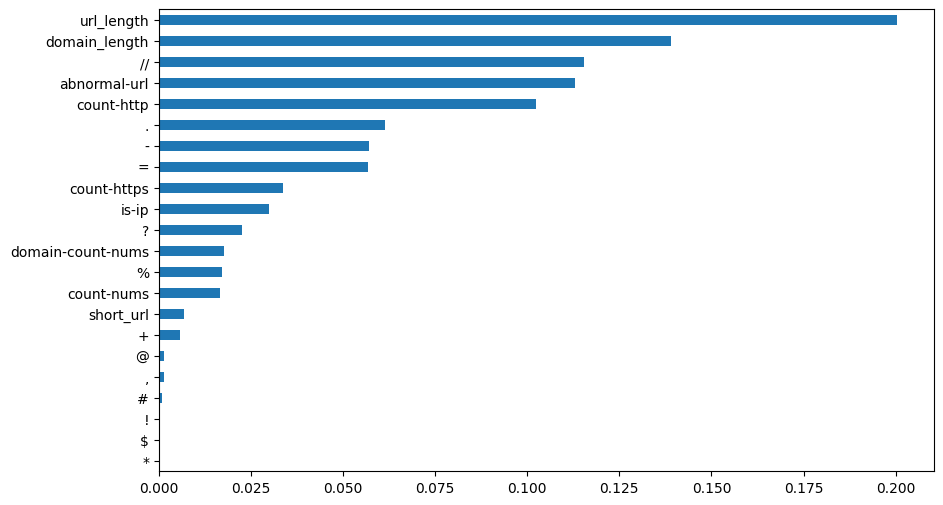

In [ ]:
feats = pd.Series(rf_model.feature_importances_, index=x_train.columns)  # random forestta hangi özelliğin ne kadar etki ettiğini görmek için bir bar grafik oluşturuyoruz.
feats.sort_values().plot(kind="barh",figsize=(10, 6))  #sort ile sıralamasını yapıyoruz. genel olarak baktığımızda uzunluğun etki ettiğini göstermiş.

In [ ]:
def parse_url(url):          #bu fonksiyon aslında yukarıda veri setinde yaptığımız özellik çıkarma işlemini , prediction yaparken verilen url üzerinde yapıcak.
  stats = []
  stats.append(short(url))
  stats.append(nums(url))
  stats.append(is_ip(url))
  stats.append(abnormal_url(url))
  for a in special_chars:
    stats.append(url.count(a))
  stats.append(url.count('https'))
  stats.append(url.count('http'))
  stats.append(len(str(url)))
  stats.append(nums(tldextract.extract(url).domain))
  stats.append(len(tldextract.extract(url).domain))

  return stats

def predict(url):
  feats = parse_url(url)   #verilen url ile metodu çalıştırıyoruz.
  feats = np.array(feats).reshape((1,-1)) #verileri 2D yapmamız gerekiyor.
  pred = rf_model.predict(feats) # tahmin işlemini yapıyoruz.

  #label encode işlemine göre bize sonuçları döndürüyor
  if int(pred[0]) == 0:
    res = "Güvenli"
    return res

  elif int(pred[0]) == 1.0:
    res = "Yanıltıcı"
    return res

  elif int(pred[0]) == 2.0:
    res = "phishing"
    return res

  elif int(pred[0]) == 3.0:
    res = "virüslü"
    return res

In [ ]:
urls = ['http://www.garage-pirenne.be/index.php?option=..','wikipedia.com',"aiseclab.org","https://tr.wi12kipedia.org/wik2i/Etnogra2fya"]

for url in urls:
  print(predict(url))